In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl for URL https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4077, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 4077 (delta 24), reused 50 (delta 17), pack-reused 4009 (from 1)
Receiving objects: 100% (4077/4077), 649.09 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (2377/2377), done.
Updating files: 100% (248/248), done.


In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Create a batch size of 32 (gthe paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

## 1. Using a Pretrained ViT from `torchvision.models`

Why use a pretrained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)

In [8]:
import torch
import torchvision.models
import torchvision.transforms as transforms
from PIL import Image

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


### 1.1 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [21]:
# gettign pre-trained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameter
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = True

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

### 1.2 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [24]:
# Get automtic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [26]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model

### 1.3 Train Feature Extractor for ViT model

In [27]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7315 | train_acc: 0.3789 | test_loss: 1.6384 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.2187 | train_acc: 0.4414 | test_loss: 2.2481 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.5624 | train_acc: 0.3320 | test_loss: 1.4269 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2105 | train_acc: 0.3594 | test_loss: 1.0661 | test_acc: 0.3220
Epoch: 5 | train_loss: 1.0348 | train_acc: 0.5352 | test_loss: 1.0666 | test_acc: 0.3532
Epoch: 6 | train_loss: 1.1374 | train_acc: 0.3867 | test_loss: 1.2373 | test_acc: 0.2803
Epoch: 7 | train_loss: 1.2213 | train_acc: 0.3711 | test_loss: 1.0441 | test_acc: 0.4536
Epoch: 8 | train_loss: 0.9100 | train_acc: 0.5664 | test_loss: 1.2105 | test_acc: 0.2812
Epoch: 9 | train_loss: 0.9529 | train_acc: 0.4883 | test_loss: 1.0268 | test_acc: 0.4517
Epoch: 10 | train_loss: 1.0041 | train_acc: 0.4805 | test_loss: 1.4875 | test_acc: 0.2917


In [28]:
### 1.4 Plot the loss curves of our pretrained ViT feature extractor model

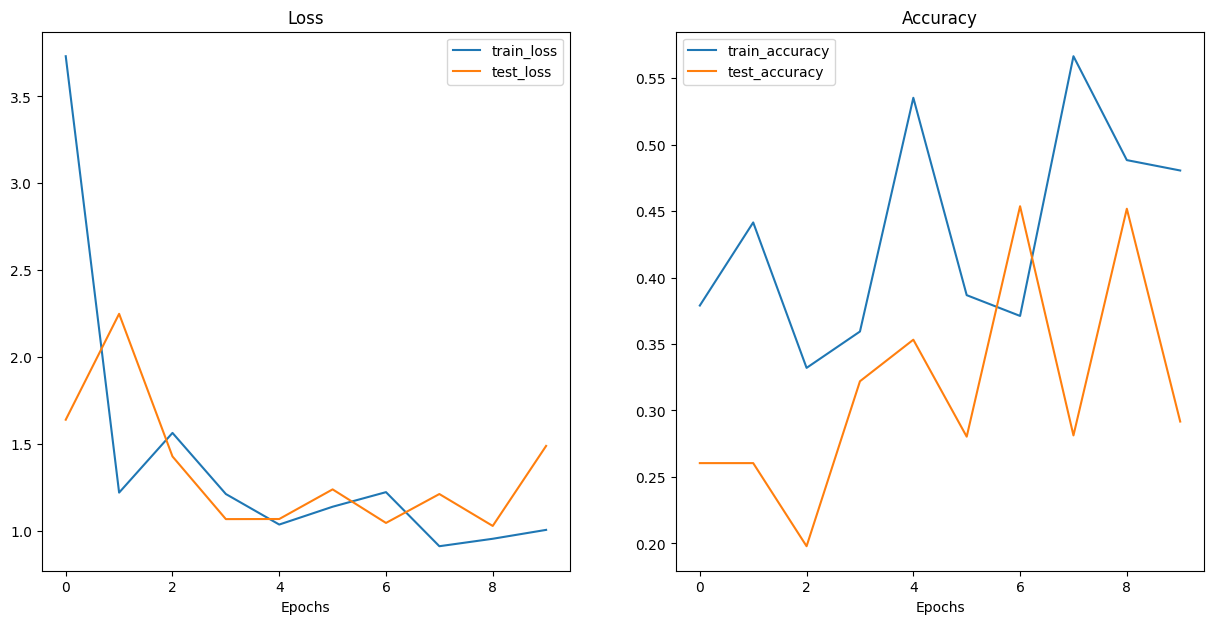

In [29]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)